# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [53]:
# Imports and device
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [54]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [55]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False, map_location=device)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


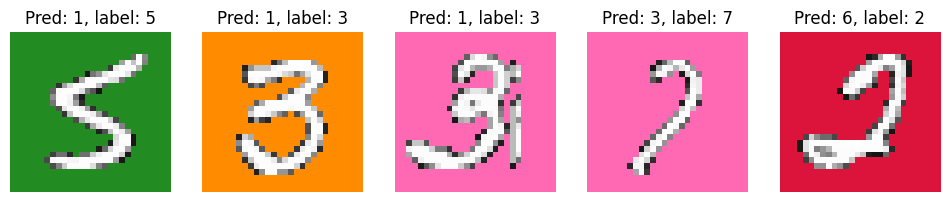

In [56]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

# labels = [5, 3, 3, 7, 2]

---
### Any code you want to add, put it below this markdown cell

In [57]:
def overlay(img_pil: Image.Image, heat_hw: np.ndarray, alpha=0.55):
    img_rgb = img_pil.convert("RGB")
    H, W = img_rgb.size[1], img_rgb.size[0]
    if heat_hw.shape != (H, W):
        heat_hw_img = Image.fromarray((np.clip(heat_hw,0,1)*255).astype(np.uint8)).resize((W,H), Image.BILINEAR)
        heat_hw = np.asarray(heat_hw_img)/255.0
    cmap = plt.get_cmap("jet")(heat_hw)[..., :3]
    base = np.asarray(img_rgb, dtype=np.float32)/255.0
    out = np.clip(alpha*cmap + (1-alpha)*base, 0, 1)
    return (out*255).astype(np.uint8)

@torch.no_grad()
def rise_saliency(model, x, target_class, N=2000, s=7, p=0.5, batch_size=128):
    """
    x: (1,C,H,W) en [0,1] en device
    N: nº de máscaras, s: granularidad, p: prob de mantener celda
    """
    model.eval()
    # Extraer dimensiones
    _, C, H, W = x.shape
    # Número de celdas en cada dimensión
    h = int(np.ceil(H / s)); w = int(np.ceil(W / s))
    # Inicializar mapa de saliencia
    sal = torch.zeros(1, 1, H, W, device=x.device)

    for start in range(0, N, batch_size):
        # Tamaño del batch
        b = min(batch_size, N - start)
        # Crear máscaras aleatorias (distribución Bernoulli)
        masks = torch.bernoulli(torch.full((b, 1, h, w), p, device=x.device))
        # Upsampling con interpolación bilineal
        masks = F.interpolate(masks, size=(H, W), mode='bilinear', align_corners=False)
        # Extender máscaras a C canales y aplicar al batch de imágenes
        x_rep = x.repeat(b, 1, 1, 1) * masks.repeat(1, C, 1, 1)
        # Obtener puntuaciones del modelo para la clase objetivo
        scores = model(x_rep)[:, target_class]        # (b,)
        # Acumular contribuciones ponderadas en el mapa de saliencia
        sal += torch.einsum('b,bchw->chw', scores, masks).unsqueeze(0)

    # Normalizar el mapa de saliencia
    sal = sal / (N * p)
    # Normalizar a [0,1]
    if sal.max() > 0:
        sal = (sal - sal.min()) / (sal.max() - sal.min())
    sal = sal.squeeze().cpu().numpy()  # (H,W) en CPU
    return sal


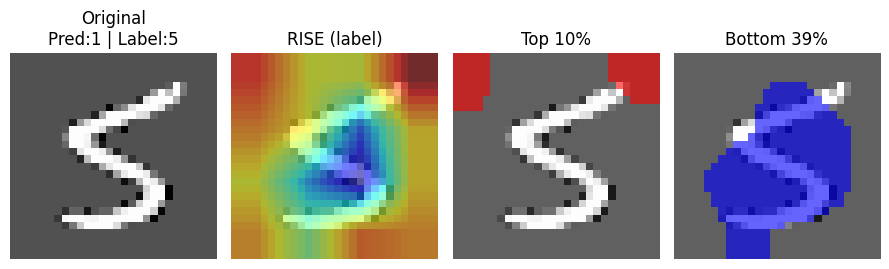

0_label5.png: Pred=1, Label=5, Explicado=label (clase 5)


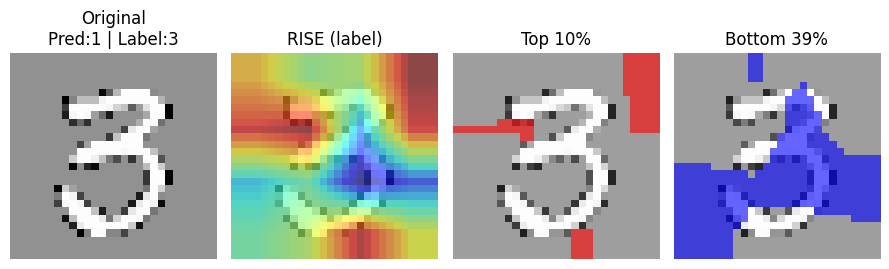

1_label3.png: Pred=1, Label=3, Explicado=label (clase 3)


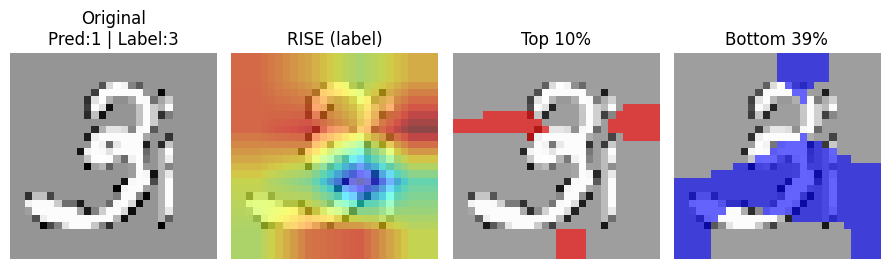

2_label3.png: Pred=1, Label=3, Explicado=label (clase 3)


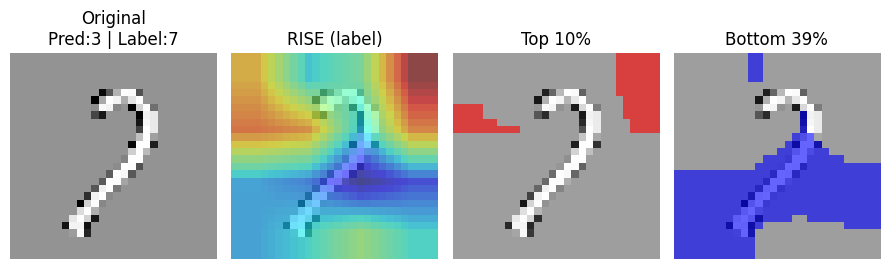

3_label7.png: Pred=3, Label=7, Explicado=label (clase 7)


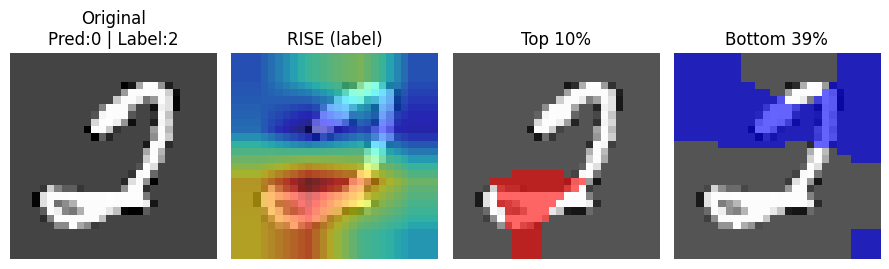

4_label2.png: Pred=0, Label=2, Explicado=label (clase 2)


In [58]:
# Extraer número de canales de entrada
for module in model.modules():
    if isinstance(module, nn.Conv2d):
        in_ch = module.in_channels
        break

TARGET   = 'label'   # 'pred' o 'label'
N_MASKS  = 2000
CELL_S   = 7
KEEP_P   = 0.5
BATCH    = 128
TOP_PCT  = 10
LOW_PCT = 39

masks_low40 = []
masks_top40 = []

# --- ejecutar una a una ---
for img_path in image_files:
    img_pil = Image.open(img_path).convert('L')
    x = transforms.functional.to_tensor(img_pil)                       # (1,H,W) [0,1]
    if in_ch == 3 and x.shape[0] == 1: x = x.repeat(3,1,1)
    if in_ch == 1 and x.shape[0] == 3: x = x[:1]
    x = x.unsqueeze(0).to(device)

    logits = model(x)
    pred = int(torch.argmax(logits, dim=1).item())
    label = int(img_path.stem[-1])
    target = pred if TARGET == 'pred' else label

    heat = rise_saliency(model, x, target, N=N_MASKS, s=CELL_S, p=KEEP_P, batch_size=BATCH)

    thr = np.percentile(heat, 100 - TOP_PCT)
    top_mask = (heat >= thr)
    masks_top40.append(top_mask)

    fig, axs = plt.subplots(1, 4, figsize=(9,3))
    axs[0].imshow(img_pil, cmap='gray'); axs[0].set_title(f'Original\nPred:{pred} | Label:{label}'); axs[0].axis('off')
    axs[1].imshow(overlay(img_pil, heat)); axs[1].set_title(f'RISE ({TARGET})'); axs[1].axis('off')

    rgb = img_pil.convert("RGB")
    base = np.asarray(rgb, dtype=np.float32)/255.0
    red = base.copy(); red[top_mask] = [1.0, 0.0, 0.0]
    # 10% of the most important pixels in red to predict the target class
    axs[2].imshow(np.clip(0.6*red + 0.4*base, 0, 1)); axs[2].set_title(f'Top {TOP_PCT}%'); axs[2].axis('off')
    # Si tapo estos pixeles baja mucho la precisión

    # Show the 40% least important pixels to predict the target class
    thr = np.percentile(heat, LOW_PCT)
    pct60_mask = (heat <= thr)
    masks_low40.append(pct60_mask)

    blue = base.copy(); blue[pct60_mask] = [0.0, 0.0, 1.0]
    # fig2, ax2 = plt.subplots(1,1, figsize=(3,3))
    # Bottom 40%
    axs[3].imshow(np.clip(0.6*blue + 0.4*base, 0, 1)); axs[3].set_title(f'Bottom {LOW_PCT}%'); axs[3].axis('off')

    plt.tight_layout(); plt.show()
    print(f"{img_path.name}: Pred={pred}, Label={label}, Explicado={TARGET} (clase {target})")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25210217..1.1325153].


dimensiones de la imagen antes de calcular los logits: torch.Size([1, 3, 28, 28])
dimensiones de la imagen antes de calcular los logits: torch.Size([1, 3, 28, 28])


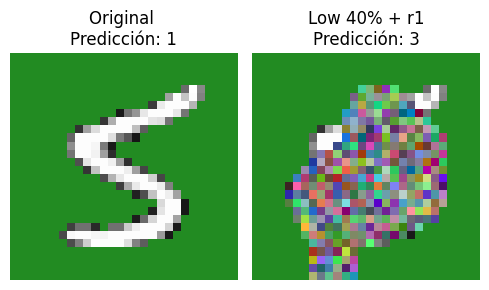

Logits1 (todos): [[ 0.6323476  -0.6332675   0.8632625  -0.6352502   0.8259519  -0.5851448
   0.51728785 -0.32150725  0.45147982 -0.11515971]]
Logits original (todos): [[ 0.775945   -1.1461053   1.148206   -1.0555245   1.2587347  -0.9557022
   0.8136112  -0.3894371   0.61685634 -0.06658426]]
Logits1 para la clase 5: -0.5851448178291321
Logits original para la clase 5: -0.9557021856307983


In [59]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Cambiar la lista de imágenes y poner la cuarta la primera
# image_files = [image_files[3]] + image_files[:3] + image_files[4:]

# Cogemos la primera máscara y la convertimos en array booleano 2D
mask_low40 = np.array(masks_low40[0], dtype=bool)
# mask_top40 = np.array(masks_top40[0], dtype=bool)

# Hacemos que la máscara sea tridimensional para aplicarla a los 3 canales
mask_low40_3d = np.stack([mask_low40] * 3, axis=-1)
# mask_top40_3d = np.stack([mask_top40] * 3, axis=-1)

# Añadimos ruido (gaussiano?) aleatorio en los píxeles dentro de la máscara
noise_level = 0.2
random_noise1 = np.random.normal(loc=0.5, scale=noise_level, size=mask_low40_3d.shape).astype(np.float32)
# random_noise1 = (np.random.rand(*mask_low40_3d.shape) < noise_level).astype(np.float32)

# random_noise2 = (np.random.rand(*mask_top40_3d.shape) < noise_level).astype(np.float32)
# random_noise2 = (np.random.rand(*mask_low40_3d.shape) < noise_level).astype(np.float32)

# Cargamos la imagen y la pasamos a array float [0,1]
img_pil = Image.open(image_files[0]).convert('RGB')
rgb = np.asarray(img_pil, dtype=np.float32) / 255.0

# Copiamos la imagen para aplicar ruido en los píxeles enmascarados
img_low40_noisy1 = rgb.copy()
# img_low40_noisy2 = rgb.copy()
# img_top40_noisy = rgb.copy()

# Sustituimos solo donde la máscara es True
img_low40_noisy1[mask_low40_3d] = random_noise1[mask_low40_3d]
# img_low40_noisy2[mask_low40_3d] = random_noise2[mask_low40_3d]
# img_top40_noisy[mask_top40_3d] = random_noise2[mask_top40_3d]

# Hacemos la predicción del modelo en las imágenes con ruido
def predict_image(model, img_array):
    model.eval()
    x = torch.tensor(img_array.transpose(2, 0, 1)).unsqueeze(0).to(device)  # (1,C,H,W)
    print('dimensiones de la imagen antes de calcular los logits:', x.shape)
    with torch.no_grad():
        logits = model(x)
        pred = int(torch.argmax(logits, dim=1).item())
        # Normalizar logits
        logits = logits / logits.sum(dim=1, keepdim=True)
    return pred, logits

pred_original, logits_original = predict_image(model, rgb)
pred_noisy1, logits_noisy1 = predict_image(model, img_low40_noisy1)
# pred_noisy2, logits_noisy2 = predict_image(model, img_top40_noisy)
# pred_noisy2, logits_noisy2 = predict_image(model, img_low40_noisy2)

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(5, 4))
axs[0].imshow(rgb); axs[0].set_title(f'Original \nPredicción: {pred_original}'); axs[0].axis('off')
axs[1].imshow(img_low40_noisy1); axs[1].set_title(f'Low 40% + r1\nPredicción: {pred_noisy1}'); axs[1].axis('off')
# axs[2].imshow(img_low40_noisy2); axs[2].set_title(f'Low 40% + r2\nPredicción: {pred_noisy2}'); axs[2].axis('off')
# axs[2].imshow(img_top40_noisy); axs[2].set_title(f'Top 40% + r2\nPredicción: {pred_noisy2}'); axs[2].axis('off')
plt.tight_layout()
plt.show()

print(f'Logits1 (todos): {logits_noisy1.cpu().numpy()}')
print(f'Logits original (todos): {logits_original.cpu().numpy()}')
# print(f'Logits top40 (todos): {logits_noisy2.cpu().numpy()}')
# print(f'Logits2 (todos): {logits_noisy2.cpu().numpy()}')
print(f'Logits1 para la clase 5: {logits_noisy1.cpu().numpy()[0][5]}')
print(f'Logits original para la clase 5: {logits_original.cpu().numpy()[0][5]}')
# print(f'Logits top40 para la clase 5: {logits_noisy2.cpu().numpy()[0][5]}')
# print(f'Logits2 para la clase 5: {logits_noisy2.cpu().numpy()[0][5]}')

In [60]:
# Ahora podemos estimar el gradiente aproximado para la clase 5
# entre la imagen original y la imagen con ruido en el 40% menos importante

img_original = torch.tensor(rgb.transpose(2, 0, 1)).unsqueeze(0).to(device)  # (1,C,H,W)
img_ruido = torch.tensor(img_low40_noisy1.transpose(2, 0, 1)).unsqueeze(0).to(device)  # (1,C,H,W)
logit_original = logits_original
logit_ruido = logits_noisy1

learning_rate = 10.0  # BIG LR
# sigma = 1.0
true_label = int(image_files[0].stem[-1])

for step in range(100):
    # Estimación del gradiente
    grad_estimate = (img_ruido - img_original) * (logit_ruido[:, true_label] - logit_original[:, true_label]).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    # Actualización de la imagen
    img_original = img_original + learning_rate * grad_estimate
    # Añadir ruido gaussiano para exploración solo en los píxeles no importantes
    noise = torch.randn_like(img_original) * (torch.tensor(mask_low40_3d.transpose(2, 0, 1)).unsqueeze(0).to(device))
    img_ruido = (img_original + noise).contiguous()
    # Obtener nueva predicción
    with torch.no_grad():
        logits_ruido = model(img_ruido)
        logits_ruido = logits_ruido / logits_ruido.sum(dim=1, keepdim=True)
    logit_ruido = logits_ruido

    pred = int(torch.argmax(logits_ruido, dim=1).item())
    print(f'Step {step+1}: Predicción con ruido: {pred}')
    # Mostrar imagen en cada iteración
    # img_to_show = img_original.squeeze().cpu().numpy().transpose(1, 2, 0)
    # plt.imshow(np.clip(img_to_show, 0, 1))
    # plt.title(f'Step {step+1}: Predicción: {pred}')
    # plt.axis('off')
    # plt.show()

# PROGRAMAR EL BUCLE A MANO!
# grad_estimate = (img_ruido - img_original) * (logit_ruido - logit_original)
# img = img + learning_rate * grad_estimate (BIG LR)


Step 1: Predicción con ruido: 9
Step 2: Predicción con ruido: 9
Step 3: Predicción con ruido: 9
Step 4: Predicción con ruido: 9
Step 5: Predicción con ruido: 9
Step 6: Predicción con ruido: 9
Step 7: Predicción con ruido: 9
Step 8: Predicción con ruido: 1
Step 9: Predicción con ruido: 1
Step 10: Predicción con ruido: 1
Step 11: Predicción con ruido: 1
Step 12: Predicción con ruido: 1
Step 13: Predicción con ruido: 9
Step 14: Predicción con ruido: 9
Step 15: Predicción con ruido: 9
Step 16: Predicción con ruido: 9
Step 17: Predicción con ruido: 9
Step 18: Predicción con ruido: 9
Step 19: Predicción con ruido: 9
Step 20: Predicción con ruido: 9
Step 21: Predicción con ruido: 9
Step 22: Predicción con ruido: 9
Step 23: Predicción con ruido: 9
Step 24: Predicción con ruido: 9
Step 25: Predicción con ruido: 9
Step 26: Predicción con ruido: 9
Step 27: Predicción con ruido: 9
Step 28: Predicción con ruido: 9
Step 29: Predicción con ruido: 9
Step 30: Predicción con ruido: 9
Step 31: Predicción

Etiqueta verdadera: 5
Step 1: ACEPTADO (con update) | p_curr=0.1844 -> p_cand=0.1844 | pred = 2
Step 2: ACEPTADO (con update) | p_curr=0.0053 -> p_cand=0.1471 | pred = 2
Step 3: ACEPTADO (con update) | p_curr=-0.0221 -> p_cand=0.1682 | pred = 2
Step 4: ACEPTADO (con update) | p_curr=-0.0543 -> p_cand=0.1533 | pred = 2
Step 5: ACEPTADO (con update) | p_curr=-0.0007 -> p_cand=0.1652 | pred = 2
Step 6: ACEPTADO (con update) | p_curr=-0.1214 -> p_cand=0.1695 | pred = 2
Step 7: ACEPTADO (con update) | p_curr=-0.0596 -> p_cand=0.1570 | pred = 2
Step 8: ACEPTADO (con update) | p_curr=-0.3588 -> p_cand=0.1316 | pred = 2
Step 9: ACEPTADO (con update) | p_curr=-0.2936 -> p_cand=0.1472 | pred = 2
Step 10: ACEPTADO (con update) | p_curr=-0.3758 -> p_cand=0.1362 | pred = 2
Step 11: ACEPTADO (con update) | p_curr=-0.0728 -> p_cand=0.1611 | pred = 2
Step 12: ACEPTADO (con update) | p_curr=-0.0709 -> p_cand=0.1550 | pred = 2
Step 13: ACEPTADO (con update) | p_curr=-0.1571 -> p_cand=0.1498 | pred = 4
S

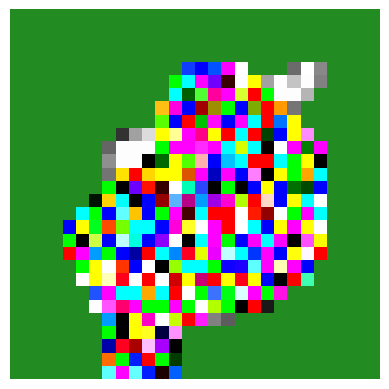

In [61]:
# Última aportación de Chati

y_true = int(Path(image_files[0]).stem[-1])  # o como tengas la label
print('Etiqueta verdadera:', y_true)

# Máscara en torch [1,3,28,28], 1 = píxeles donde SÍ quieres tocar
mask_torch = torch.tensor(
    mask_low40_3d.transpose(2, 0, 1),  # [28,28,3] -> [3,28,28]
    device=device,
    dtype=torch.float32
).unsqueeze(0)  # [1,3,28,28]

img_current = img_original.contiguous().to(device)

with torch.no_grad():
    logits_current = model(img_current)
    logits_current = logits_current / logits_current.sum(dim=1, keepdim=True)

for step in range(100):
    # 1) Ruido solo dentro de la máscara
    noise = torch.randn_like(img_current) * mask_torch
    img_candidate = img_current + noise

    # 2) Predicción con la imagen candidata
    with torch.no_grad():
        logits_candidate = model(img_candidate)
        logits_candidate = logits_candidate / logits_candidate.sum(dim=1, keepdim=True)

    # 3) Probabilidad de la clase verdadera
    p_curr = logits_current[:, y_true]     # [1]
    p_cand = logits_candidate[:, y_true]   # [1]

    # 4) ¿Ayuda la imagen ruidosa?
    if p_cand > p_curr:
        # ---- AQUÍ HACES EL GRAD_ESTIMATE ----
        delta = (p_cand - p_curr).reshape(-1, 1, 1, 1)  # [1,1,1,1]
        # gradiente solo en la máscara
        grad_estimate = (img_candidate - img_current) * delta * mask_torch  # [1,3,28,28]

        # Actualizas la imagen en la dirección del gradiente
        img_current = img_current + learning_rate * grad_estimate

        # (opcional) recortas al rango válido
        img_current = img_current.clamp(0.0, 1.0)

        # Actualizas logits para la nueva imagen
        with torch.no_grad():
            logits_current = model(img_current)
            logits_current = logits_current / logits_current.sum(dim=1, keepdim=True)

        estado = "ACEPTADO (con update)"
    else:
        # No haces grad_estimate ni tocas la imagen
        estado = "RECHAZADO"

    pred = int(torch.argmax(logits_current, dim=1).item())
    print(
        f"Step {step+1}: {estado} | "
        f"p_curr={p_curr.item():.4f} -> p_cand={p_cand.item():.4f} | "
        f"pred = {pred}"
    )

# Imagen final
plt.imshow(img_current[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="gray")
plt.axis("off")
plt.show()


In [65]:
#Chat modificación 2 celdas arriba
# Imagen original y con ruido inicial (a partir de tus arrays numpy)
img_original = torch.tensor(rgb.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device).contiguous()  # (1,C,H,W)
img_ruido    = torch.tensor(img_low40_noisy1.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)  # (1,C,H,W)

true_label = int(image_files[0].stem[-1])

# Máscara en torch: [1, 3, 28, 28], 1 = píxeles donde SÍ quieres tocar
mask_torch = torch.tensor(
    mask_low40_3d.transpose(2, 0, 1),  # [28,28,3] -> [3,28,28]
    dtype=torch.float32,
    device=device,
).unsqueeze(0)  # [1,3,28,28]

learning_rate = 0.001  # LR mucho más razonable
pred = -1
step = 0

for step in range(100):
# while not pred == true_label:
    # --- logits de la imagen actual (actualizamos SIEMPRE) ---
    with torch.no_grad():
        logits_original = model(img_original)
        logits_original = logits_original / logits_original.sum(dim=1, keepdim=True)
        p_orig = logits_original[:, true_label]  # prob de la clase verdadera con la imagen actual

    # --- generar ruido SOLO en la máscara ---
    noise = torch.randn_like(img_original) * mask_torch
    img_ruido = (img_original + noise).contiguous()

    # --- logits de la imagen ruidosa ---
    with torch.no_grad():
        logits_ruido = model(img_ruido)
        logits_ruido = logits_ruido / logits_ruido.sum(dim=1, keepdim=True)
        p_ruido = logits_ruido[:, true_label]  # prob de la clase verdadera con la imagen ruidosa

    # --- criterio de aceptación: ¿el ruido ayuda? ---
    if p_ruido > p_orig:
        # Escalar delta (cuánto mejora la prob de la clase correcta)
        delta = (p_ruido - p_orig).reshape(-1, 1, 1, 1)  # [1,1,1,1]

        # Gradiente aproximado, SOLO en la máscara
        grad_estimate = (img_ruido - img_original) * delta * mask_torch  # [1,3,28,28]

        # Actualización de la imagen
        img_original = img_original + learning_rate * grad_estimate

        # Mantener píxeles en rango válido (si trabajas en [0,1])
        img_original = img_original.clamp(0.0, 1.0)

        estado = "ACEPTADO"
        pred = int(torch.argmax(logits_ruido, dim=1).item())
    else:
        # No tocamos img_original si el ruido empeora la clase correcta
        estado = "RECHAZADO"
        pred = int(torch.argmax(logits_original, dim=1).item())

    step += 1
    print(
        f"Step {step}: {estado} | "
        f"p_orig={p_orig.item():.4f} -> p_ruido={p_ruido.item():.4f} | "
        f"pred={pred}"
    )
    if pred == true_label:
        print("¡Ya clasifica correctamente, paro aquí!")
        # Guardamos la imagen final
        img_np = img_original[0].permute(1, 2, 0).detach().cpu().numpy()  # [28,28,3]
        img_pil_final = Image.fromarray((img_np * 255).astype(np.uint8))
        img_pil_final.save('imagen_modificada_correcta.png')
        plt.imshow(img_np)
        plt.axis("off")
        plt.show()
        break


Step 1: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1389 | pred=9
Step 2: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.0830 | pred=2
Step 3: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1461 | pred=1
Step 4: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1500 | pred=9
Step 5: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1599 | pred=1
Step 6: RECHAZADO | p_orig=-0.9557 -> p_ruido=-0.9557 | pred=4
Step 7: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.0137 | pred=9
Step 8: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1157 | pred=9
Step 9: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1640 | pred=9
Step 10: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1150 | pred=1
Step 11: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1180 | pred=9
Step 12: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1315 | pred=9
Step 13: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1277 | pred=9
Step 14: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.0290 | pred=9
Step 15: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.0314 | pred=0
Step 16: ACEPTADO | p_orig=-0.9557 -> p_ruido=0.1067 | pred=9
Step 17: ACEPTA

In [ ]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False, map_location=device)

# Prueba con gradient ascent simple
img_pil = Image.open(image_files[0]).convert('RGB')
rgb = np.asarray(img_pil, dtype=np.float32) / 255.0
img_current = torch.tensor(rgb.transpose(2, 0, 1)).unsqueeze(0).to(device)  # (1,C,H,W)

mask_torch = torch.tensor(
    mask_low40_3d.transpose(2, 0, 1),  # [28,28,3] -> [3,28,28]
    device=device,
    dtype=torch.float32
).unsqueeze(0)  # [1,3,28,28]

true_label = int(image_files[0].stem[-1])
learning_rate = 0.01
pred = -1
step = 0

# print('grad', torch.is_grad_enabled())
torch.set_grad_enabled(True)

while not pred == true_label:
    img_current = img_current.detach()
    img_current = img_current.requires_grad_(True).contiguous()

    logits = model(img_current)
    print('logits', logits.grad)
    probs = torch.nn.functional.softmax(logits, dim=1)
    logit_true = logits[0, true_label]
    print('logit_true', logit_true.requires_grad)

    model.zero_grad()
    print('img_grad before backward', img_current.grad)
    if img_current.grad is not None:
        img_current.grad.zero_()

    print('backward', logit_true.requires_grad)
    logit_true.backward()

    grad = img_current.grad
    # gradiente_img = torch.autograd.grad(logit_true, img_current, retain_graph=True, create_graph=False)
    if grad is None:
        print('grad is None!')

    # Aplicar gradiente solo en la máscara
    with torch.no_grad():
        img_current = img_current + learning_rate * grad * mask_torch
        img_current = img_current.clamp(0.0, 1.0)

    img_current = img_current.detach()

    pred = int(torch.argmax(logits, dim=1).item())
    p_true = probs[0, true_label].item()
    step += 1
    print(f"Step {step}: Pred={pred}, p_true={p_true:.4f}")

    if pred == true_label:
        print("¡Ya clasifica correctamente, paro aquí!")
        img_np = img_current[0].permute(1, 2, 0).detach().cpu().numpy()  # [28,28,3]
        img_pil_final = Image.fromarray((img_np * 255).astype(np.uint8))
        img_pil_final.save('imagen_modificada_gradient_ascent.png')
        plt.imshow(img_np)
        plt.axis("off")
        plt.show()
        break


logits None
logit_true True
img_grad before backward None
backward True


C:\Users\victo\AppData\Local\Temp\ipykernel_21260\236469215.py:29: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  print('logits', logits.grad)
C:\Users\victo\AppData\Local\Temp\ipykernel_21260\236469215.py:35: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access 

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

---
## Check if you have passed the challenge 

In [ ]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [ ]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 3_label7.png: Pred: 3, Label: 7, correct: False
Edit Percentage: 0.00%
Edited 1_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 0.00%
Edited 4_label2.png: Pred: 6, Label: 2, correct: False
Edit Percentage: 0.00%
Edited 2_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 0.00%
Edited 0_label5.png: Pred: 1, Label: 5, correct: False
Edit Percentage: 0.00%
